PyTorch UNet implementation using IceNet library for data download and post-processing of sea ice forecasting.

This notebook is independent of other notebooks.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.set_float32_matmul_precision('medium')

In [2]:
import numpy as np
import pandas as pd
import os
import random
import matplotlib.pyplot as plt

# We also set the logging level so that we get some feedback from the API
import logging
logging.basicConfig(level=logging.INFO)

In [3]:
# Quick hack to put us in the icenet-pipeline folder,
# assuming it was created as per 01.cli_demonstration.ipynb
import os
if os.path.exists("1_icenet2_forecast_unet.ipynb"):
    os.chdir("../../notebook-pipeline")
print("Running in {}".format(os.getcwd()))

%matplotlib inline

Running in /data/hpcdata/users/bryald/git/icenet/notebook-pipeline


## Download

In [4]:
from icenet.data.sic.mask import Masks
from icenet.data.interfaces.cds import ERA5Downloader
from icenet.data.sic.osisaf import SICDownloader

### Mask data

Create masks for masking data.

In [5]:
masks = Masks(north=False, south=True)
masks.generate(save_polarhole_masks=False)

INFO:root:siconca ice_conc_sh_ease2-250_cdr-v2p0_200001021200.nc already exists
INFO:root:Saving ./data/masks/south/masks/active_grid_cell_mask_01.npy
INFO:root:siconca ice_conc_sh_ease2-250_cdr-v2p0_200002021200.nc already exists
INFO:root:Saving ./data/masks/south/masks/active_grid_cell_mask_02.npy
INFO:root:siconca ice_conc_sh_ease2-250_cdr-v2p0_200003021200.nc already exists
INFO:root:Saving ./data/masks/south/masks/active_grid_cell_mask_03.npy
INFO:root:siconca ice_conc_sh_ease2-250_cdr-v2p0_200004021200.nc already exists
INFO:root:Saving ./data/masks/south/masks/active_grid_cell_mask_04.npy
INFO:root:siconca ice_conc_sh_ease2-250_cdr-v2p0_200005021200.nc already exists
INFO:root:Saving ./data/masks/south/masks/active_grid_cell_mask_05.npy
INFO:root:siconca ice_conc_sh_ease2-250_cdr-v2p0_200006021200.nc already exists
INFO:root:Saving ./data/masks/south/masks/active_grid_cell_mask_06.npy
INFO:root:siconca ice_conc_sh_ease2-250_cdr-v2p0_200007021200.nc already exists
INFO:root:Savi

### Climate and Sea Ice data

Download climate variables from ERA5 and sea ice concentration from OSI-SAF.

In [6]:
era5 = ERA5Downloader(
    var_names=["tas", "zg", "uas", "vas"],
    levels=[None, [250, 500], None, None],
    dates=[pd.to_datetime(date).date() for date in
           pd.date_range("2020-01-01", "2020-04-30", freq="D")],
    delete_tempfiles=False,
    max_threads=64,
    north=False,
    south=True,
    # NOTE: there appears to be a bug with the toolbox API at present (icenet#54)
    use_toolbox=False
)

era5.download()

INFO:root:Upping connection limit for max_threads > 10
INFO:root:Building request(s), downloading and daily averaging from ERA5 API
INFO:root:Processing single download for tas @ None with 121 dates
INFO:root:Processing single download for zg @ 250 with 121 dates
INFO:root:Processing single download for zg @ 500 with 121 dates
INFO:root:Processing single download for uas @ None with 121 dates
INFO:root:Processing single download for vas @ None with 121 dates
INFO:root:No requested dates remain, likely already present
INFO:root:No requested dates remain, likely already present
INFO:root:No requested dates remain, likely already present
INFO:root:No requested dates remain, likely already present
INFO:root:No requested dates remain, likely already present
INFO:root:0 daily files downloaded


In [7]:
sic = SICDownloader(
    dates=[pd.to_datetime(date).date() for date in
           pd.date_range("2020-01-01", "2020-04-30", freq="D")],
    delete_tempfiles=False,
    north=False,
    south=True,
    parallel_opens=False,
)

sic.download()

INFO:root:Downloading SIC datafiles to .temp intermediates...
INFO:root:Excluding 121 dates already existing from 121 dates requested.
INFO:root:Existing file needs concatenating: ./data/osisaf/south/siconca/2020.nc -> ./data/osisaf/south/siconca/old.2020.nc
INFO:root:Saving ./data/osisaf/south/siconca/2020.nc
INFO:root:Opening for interpolation: ['./data/osisaf/south/siconca/2020.nc']
INFO:root:Processing 0 missing dates


Re-grid ERA5 reanalysis data, and rotate wind vector data from ERA5 to align with EASE2 projection.

In [8]:
era5.regrid()
era5.rotate_wind_data()

INFO:root:No regrid batches to processing, moving on...
INFO:root:Rotating wind data prior to merging
/data/hpcdata/users/bryald/git/icenet/icenet/icenet/data/interfaces/downloader.py:361: FutureWarning: Ignoring a datum in netCDF load for consistency with existing behaviour. In a future version of Iris, this datum will be applied. To apply the datum when loading, use the iris.FUTURE.datum_support flag.
  iris.load_cube(sic_day_path, 'sea_ice_area_fraction')
/data/hpcdata/users/bryald/git/icenet/icenet/icenet/data/interfaces/downloader.py:361: FutureWarning: Ignoring a datum in netCDF load for consistency with existing behaviour. In a future version of Iris, this datum will be applied. To apply the datum when loading, use the iris.FUTURE.datum_support flag.
  iris.load_cube(sic_day_path, 'sea_ice_area_fraction')
/data/hpcdata/users/bryald/git/icenet/icenet/icenet/data/interfaces/downloader.py:361: FutureWarning: Ignoring a datum in netCDF load for consistency with existing behaviour. I

### Processor

Process downloaded datasets.

To make life easier, setting up train, val, test dates.

In [9]:
processing_dates = dict(
    train=[pd.to_datetime(el) for el in pd.date_range("2020-01-01", "2020-03-31")],
    val=[pd.to_datetime(el) for el in pd.date_range("2020-04-03", "2020-04-23")],
    test=[pd.to_datetime(el) for el in pd.date_range("2020-04-01", "2020-04-02")],
)
processed_name = "notebook_api_pytorch_data"

Next, we create the data producer and configure them for the dataset we want to create.

In [10]:
from icenet.data.processors.era5 import IceNetERA5PreProcessor
from icenet.data.processors.meta import IceNetMetaPreProcessor
from icenet.data.processors.osi import IceNetOSIPreProcessor

pp = IceNetERA5PreProcessor(
    ["uas", "vas"],
    ["tas", "zg500", "zg250"],
    processed_name,
    processing_dates["train"],
    processing_dates["val"],
    processing_dates["test"],
    linear_trends=tuple(),
    north=False,
    south=True
)

osi = IceNetOSIPreProcessor(
    ["siconca"],
    [],
    processed_name,
    processing_dates["train"],
    processing_dates["val"],
    processing_dates["test"],
    linear_trends=tuple(),
    north=False,
    south=True
)

meta = IceNetMetaPreProcessor(
    processed_name,
    north=False,
    south=True
)

Next, we initialise the data processors using `init_source_data` which scans the data source directories to understand what data is available for processing based on the parameters. Since we named the processed data `"notebook_api_data"` above, it will create a data loader config file, `loader.notebook_api_data.json`, in the current directory.

In [11]:
# Causes hanging on training, when generating sample.
pp.init_source_data(
    lag_days=1,
)
pp.process()

osi.init_source_data(
    lag_days=1,
)
osi.process()

meta.process()

INFO:root:Processing 91 dates for train category
INFO:root:Including lag of 1 days
INFO:root:Including lead of 93 days
INFO:root:No data found for 2019-12-31, outside data boundary perhaps?
INFO:root:Processing 21 dates for val category
INFO:root:Including lag of 1 days
INFO:root:Including lead of 93 days
INFO:root:Processing 2 dates for test category
INFO:root:Including lag of 1 days
INFO:root:Including lead of 93 days
INFO:root:Got 1 files for tas
INFO:root:Got 1 files for uas
INFO:root:Got 1 files for vas
INFO:root:Got 1 files for zg250
INFO:root:Got 1 files for zg500
INFO:root:Opening files for uas
INFO:root:Filtered to 121 units long based on configuration requirements
INFO:root:Normalising uas
INFO:root:Opening files for vas
INFO:root:Filtered to 121 units long based on configuration requirements
INFO:root:Normalising vas
INFO:root:Opening files for tas
INFO:root:Filtered to 121 units long based on configuration requirements
INFO:root:Reusing climatology ./processed/notebook_api_

At this point the preprocessed data is ready to convert or create a configuration for the network dataset.

### Dataset creation

As with the `icenet_dataset_create` command we can create a dataset configuration for training the network. As before this can include cached data for the network in the format of a TFRecordDataset compatible set of tfrecords. To achieve this we create the `IceNetDataLoader`, which can both generate `IceNetDataSet` configurations (which easily provide the necessary functionality for training and prediction) as well as individual data samples for direct usage.

In [12]:
from icenet.data.loaders import IceNetDataLoaderFactory

implementation = "dask"
loader_config = "loader.notebook_api_pytorch_data.json"
dataset_name = "api_pytorch_dataset"
lag = 1

dl = IceNetDataLoaderFactory().create_data_loader(
    implementation,
    loader_config,
    dataset_name,
    lag,
    n_forecast_days=7,
    north=False,
    south=True,
    output_batch_size=1,
    generate_workers=4)

INFO:root:Loading configuration loader.notebook_api_pytorch_data.json


At this point we can either use `generate` or `write_dataset_config_only` to produce a ready-to-go `IceNetDataSet` configuration. Both of these will generate a dataset config, `dataset_config.api_pytorch_dataset.json` (recall we set the dataset name as `api_pytorch_dataset` above).

In this case, for pytorch, will read data in directly, rather than using cached tfrecords inputs.

In [13]:
dl.write_dataset_config_only()

INFO:root:Writing dataset configuration without data generation
INFO:root:91 train dates in total, NOT generating cache data.
INFO:root:21 val dates in total, NOT generating cache data.
INFO:root:2 test dates in total, NOT generating cache data.
INFO:root:Writing configuration to ./dataset_config.api_pytorch_dataset.json


## Train

For single runs we programmatically can call the same method used by the CLI. `train_model` defines the training process from start to finish. The [`model-ensembler`](https://github.com/JimCircadian/model-ensembler) works outside the API, controlling multiple CLI submissions. Customising an ensemble can be achieved through looking at the configuration in [the pipeline repository](https://github.com/antarctica/IceNet-Pipeline). That said, if workflow system integration (e.g. Airflow) is desired, integrating via this method is the way to go.

We can now create the IceNetDataSet object:

In [14]:
from icenet.data.dataset import IceNetDataSetPyTorch
dataset_config = "dataset_config.api_pytorch_dataset.json"

In [15]:
batch_size = 4
shuffle = False
# persistent_workers=True
# num_workers = 4
persistent_workers=True
num_workers = 4

## IceNet2 UNet model

PyTorch UNet implementation based on current state of IceNet2, and Andrew's work from https://github.com/ampersandmcd/icenet-gan/.

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Interpolate(nn.Module):
    def __init__(self, scale_factor, mode):
        super().__init__()
        self.interp = F.interpolate
        self.scale_factor = scale_factor
        self.mode = mode

    def forward(self, x):
        x = self.interp(x, scale_factor=self.scale_factor, mode=self.mode)
        return x

class UNet(nn.Module):
    def __init__(self,
                 input_channels,
                 filter_size=3,
                 n_filters_factor=1,
                 n_forecast_days=7,
                 n_output_classes=1,
                 **kwargs
                 ):
        super(UNet, self).__init__()

        self.input_channels = input_channels
        self.filter_size = filter_size
        self.n_filters_factor = n_filters_factor
        self.n_forecast_days = n_forecast_days
        self.n_output_classes = n_output_classes

        start_out_channels = 64
        reduced_channels = int(start_out_channels * n_filters_factor)
        channels = {
            start_out_channels * 2**pow: reduced_channels * 2**pow
            for pow in range(4)
        }

        # Encoder
        self.conv1 = self.conv_block(input_channels, channels[64])
        self.conv2 = self.conv_block(channels[64], channels[128])
        self.conv3 = self.conv_block(channels[128], channels[256])
        self.conv4 = self.conv_block(channels[256], channels[256])

        # Bottleneck
        self.conv5 = self.bottleneck_block(channels[256], channels[512])

        # Decoder
        self.up6 = self.upconv_block(channels[512], channels[256])
        self.up7 = self.upconv_block(channels[256], channels[256])
        self.up8 = self.upconv_block(channels[256], channels[128])
        self.up9 = self.upconv_block(channels[128], channels[64])

        self.up6b = self.conv_block(channels[512], channels[256])
        self.up7b = self.conv_block(channels[512], channels[256])
        self.up8b = self.conv_block(channels[256], channels[128])
        self.up9b = self.conv_block(channels[128], channels[64], final=True)

        # Final layer
        self.final_layer = nn.Conv2d(channels[64], n_forecast_days, kernel_size=1, padding="same")

    def forward(self, x):
        # transpose from shape (b, h, w, c) to (b, c, h, w) for pytorch conv2d layers
        x = torch.movedim(x, -1, 1)  # move c from last to second dim

        # Encoder
        bn1 = self.conv1(x)
        conv1 = F.max_pool2d(bn1, kernel_size=2)
        bn2 = self.conv2(conv1)
        conv2 = F.max_pool2d(bn2, kernel_size=2)
        bn3 = self.conv3(conv2)
        conv3 = F.max_pool2d(bn3, kernel_size=2)
        bn4 = self.conv4(conv3)
        conv4 = F.max_pool2d(bn4, kernel_size=2)

        # Bottleneck
        bn5 = self.conv5(conv4)

        # Decoder
        up6 = self.up6b(torch.cat([bn4, self.up6(bn5)], dim=1))
        up7 = self.up7b(torch.cat([bn3, self.up7(up6)], dim=1))
        up8 = self.up8b(torch.cat([bn2, self.up8(up7)], dim=1))
        up9 = self.up9b(torch.cat([bn1, self.up9(up8)], dim=1))

        # Final layer
        output = self.final_layer(up9)

        # transpose from shape (b, c, h, w) back to (b, h, w, c) to align with training data
        output = torch.movedim(output, 1, -1)  # move c from second to final dim

        b, h, w, c = output.shape

        # unpack c=classes*months dimension into classes, months as separate dimensions
        output = output.reshape((b, h, w, self.n_output_classes, self.n_forecast_days))

        return output

    def conv_block(self, in_channels, out_channels, final=False):
        block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=self.filter_size, padding="same"),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=self.filter_size, padding="same"),
            nn.ReLU(inplace=True),
        )
        if not final:
            batch_norm = nn.Sequential(
                nn.BatchNorm2d(num_features=out_channels),
            )
            return nn.Sequential().extend(block).extend(batch_norm)
        else:
            final_block = nn.Sequential(
                nn.Conv2d(out_channels, out_channels, kernel_size=self.filter_size, padding="same"),
                nn.ReLU(inplace=True),
            )
            return nn.Sequential().extend(block).extend(final_block)


    def bottleneck_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=self.filter_size, padding="same"),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=self.filter_size, padding="same"),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_features=out_channels),
        )

    def upconv_block(self, in_channels, out_channels):
        return nn.Sequential(
            Interpolate(scale_factor=2, mode='nearest'),
            nn.Conv2d(in_channels, out_channels, kernel_size=2, padding="same"),
            nn.ReLU(inplace=True)
        )

Define custom metrics for use in validation and monitoring

In [17]:
from torchmetrics import Metric

class IceNetAccuracy(Metric):
    """Binary accuracy metric for use at multiple leadtimes.

    Reference: https://lightning.ai/docs/torchmetrics/stable/pages/implement.html
    """    

    # Set class properties
    is_differentiable: bool = False
    higher_is_better: bool = True
    full_state_update: bool = True

    def __init__(self, leadtimes_to_evaluate: list):
        """Custom loss/metric for binary accuracy in classifying SIC>15% for multiple leadtimes.

        Args:
            leadtimes_to_evaluate: A list of leadtimes to consider
                e.g., [0, 1, 2, 3, 4, 5] to consider first six days in accuracy computation or
                e.g., [0] to only look at the first day's accuracy
                e.g., [5] to only look at the sixth day's accuracy
        """
        super().__init__()
        self.leadtimes_to_evaluate = leadtimes_to_evaluate
        self.add_state("weighted_score", default=torch.tensor(0.), dist_reduce_fx="sum")
        self.add_state("possible_score", default=torch.tensor(0.), dist_reduce_fx="sum")

    def update(self, preds: torch.Tensor, target: torch.Tensor, sample_weight: torch.Tensor):
        # preds and target are shape (b, h, w, t)
        preds = (preds > 0.15).long() # torch.Size([2, 432, 432, 7])
        target = (target > 0.15).long() # torch.Size([2, 432, 432, 7])
        base_score = preds[:, :, :, self.leadtimes_to_evaluate] == target[:, :, :, self.leadtimes_to_evaluate]
        self.weighted_score += torch.sum(base_score * sample_weight[:, :, :, self.leadtimes_to_evaluate])
        self.possible_score += torch.sum(sample_weight[:, :, :, self.leadtimes_to_evaluate])

    def compute(self):
        return self.weighted_score.float() / self.possible_score * 100.0


class SIEError(Metric):
    """
    Sea Ice Extent error metric (in km^2) for use at multiple leadtimes.
    """ 

    # Set class properties
    is_differentiable: bool = False
    higher_is_better: bool = False
    full_state_update: bool = True

    def __init__(self, leadtimes_to_evaluate: list):
        """Construct an SIE error metric (in km^2) for use at multiple leadtimes.
            leadtimes_to_evaluate: A list of leadtimes to consider
                e.g., [0, 1, 2, 3, 4, 5] to consider six days in computation or
                e.g., [0] to only look at the first day
                e.g., [5] to only look at the sixth day
        """
        super().__init__()
        self.leadtimes_to_evaluate = leadtimes_to_evaluate
        self.add_state("pred_sie", default=torch.tensor(0.), dist_reduce_fx="sum")
        self.add_state("true_sie", default=torch.tensor(0.), dist_reduce_fx="sum")

    def update(self, preds: torch.Tensor, target: torch.Tensor, sample_weight: torch.Tensor):
        # preds and target are shape (b, h, w, t)
        preds = (preds > 0.15).long()
        target = (target > 0.15).long()
        self.pred_sie += preds[:, :, :, self.leadtimes_to_evaluate].sum()
        self.true_sie += target[:, :, :, self.leadtimes_to_evaluate].sum()

    def compute(self):
        return (self.pred_sie - self.true_sie) * 25**2 # each pixel is 25x25 km

Define custom loss functions

In [18]:
class WeightedBCEWithLogitsLoss(nn.BCEWithLogitsLoss):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def forward(self, inputs, targets, sample_weights):
        """
        Weighted BCEWithLogitsLoss loss.

        Compute BCEWithLogitsLoss loss weighted by masking.

        Using BCEWithLogitsLoss instead of BCELoss, as pytorch docs mentions it is
        more numerically stable.
        https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html
        
        """
        # Computing using nn.BCEWithLogitsLoss base class. This class must be instantiated via:
        # >>> criterion = WeightedBCEWithLogitsLoss(reduction='none')
        loss = super().forward(
                            (inputs.movedim(-2, 1)),
                            (targets.movedim(-1, 1))
                         )*sample_weights.movedim(-1, 1)
        
        return loss.mean()

class WeightedL1Loss(nn.L1Loss):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def forward(self, inputs, targets, sample_weights):
        """
        Weighted L1 loss.

        Compute L1 loss weighted by masking.
        
        """
        y_hat = torch.sigmoid(inputs)

        # Computing using nn.L1Loss class. This class must be instantiated via:
        # >>> criterion = WeightedL1Loss(reduction="none")
        loss = super().forward(
                            (100*y_hat.movedim(-2, 1)), 
                            (100*targets.movedim(-1, 1))
                         )*sample_weights.movedim(-1, 1)


        # Computing here, in the derived class
        # loss = (
        #             torch.abs( ( y_hat.movedim(-2, 1) - targets.movedim(-1, 1) )*100 )
        #         )*sample_weights.movedim(-1, 1)
        
        return loss.mean()

class WeightedMSELoss(nn.MSELoss):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def forward(self, inputs, targets, sample_weights):
        """
        Weighted MSE loss.

        Compute MSE loss weighted by masking.
        
        """
        y_hat = torch.sigmoid(inputs)

        # Computing using nn.MSELoss base class. This class must be instantiated via:
        # criterion = nn.MSELoss(reduction="none")
        loss = super().forward(
                            (100*y_hat.movedim(-2, 1)), 
                            (100*targets.movedim(-1, 1))
                         )*sample_weights.movedim(-1, 1)


        # Computing here, in the nn.Module derived class
        # loss = (
        #             ( ( y_hat.movedim(-2, 1) - targets.movedim(-1, 1) )*100 )**2
        #         )*sample_weights.movedim(-1, 1)
        return loss.mean()

A _LightningModule_ wrapper for UNet model.

In [19]:
import lightning.pytorch as pl
from lightning.pytorch.utilities.types import TRAIN_DATALOADERS
from torchmetrics import MetricCollection

class LitUNet(pl.LightningModule):
    """
    A LightningModule wrapping the UNet implementation of IceNet.
    """
    def __init__(self,
                 model: nn.Module,
                 criterion: callable,
                 learning_rate: float):
        """
        Construct a UNet LightningModule.
        Note that we keep hyperparameters separate from dataloaders to prevent data leakage at test time.
        :param model: PyTorch model
        :param criterion: PyTorch loss function for training instantiated with reduction="none"
        :param learning_rate: Float learning rate for our optimiser
        """
        super().__init__()
        self.model = model
        self.criterion = criterion
        self.learning_rate = learning_rate
        self.n_output_classes = model.n_output_classes  # this should be a property of the network

        metrics = {
            "val_accuracy": IceNetAccuracy(leadtimes_to_evaluate=list(range(self.model.n_forecast_days))),
            "val_sieerror": SIEError(leadtimes_to_evaluate=list(range(self.model.n_forecast_days)))
        }
        for i in range(self.model.n_forecast_days):
            metrics[f"val_accuracy_{i}"] = IceNetAccuracy(leadtimes_to_evaluate=[i])
            metrics[f"val_sieerror_{i}"] = SIEError(leadtimes_to_evaluate=[i])
        self.metrics = MetricCollection(metrics)

        test_metrics = {
            "test_accuracy": IceNetAccuracy(leadtimes_to_evaluate=list(range(self.model.n_forecast_days))),
            "test_sieerror": SIEError(leadtimes_to_evaluate=list(range(self.model.n_forecast_days)))
        }
        for i in range(self.model.n_forecast_days):
            test_metrics[f"test_accuracy_{i}"] = IceNetAccuracy(leadtimes_to_evaluate=[i])
            test_metrics[f"test_sieerror_{i}"] = SIEError(leadtimes_to_evaluate=[i])
        self.test_metrics = MetricCollection(test_metrics)

        # Save input parameters to __init__ (hyperparams) when checkpointing.
        # self.save_hyperparameters(ignore=["model", "criterion"])
        self.save_hyperparameters()

    def forward(self, x):
        """
        Implement forward function.
        :param x: Inputs to model.
        :return: Outputs of model.
        """
        return self.model(x)

    def training_step(self, batch):
        """
        Perform a pass through a batch of training data.
        Apply pixel-weighted loss by manually reducing.
        See e.g. https://discuss.pytorch.org/t/unet-pixel-wise-weighted-loss-function/46689/5.
        :param batch: Batch of input, output, weight triplets
        :param batch_idx: Index of batch
        :return: Loss from this batch of data for use in backprop
        """
        x, y, sample_weight = batch
        outputs = self.model(x)
        # y_hat = torch.sigmoid(outputs)

        # loss = loss_func(outputs, y, sample_weight)
        loss = self.criterion(outputs, y, sample_weight)

        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, sync_dist=True)
        return {"loss": loss}

    def validation_step(self, batch):
        # x: (b, h, w, channels), y: (b, h, w, n_forecast_days, classes), sample_weight: (b, h, w, n_forecast_days, classes)
        x, y, sample_weight = batch
        # y_hat: (b, h, w, classes, n_forecast_days)
        outputs = self.model(x)
        y_hat = torch.sigmoid(outputs)

        # loss = loss_func(outputs, y, sample_weight)
        loss = self.criterion(outputs, y, sample_weight)

        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True, sync_dist=True)  # epoch-level loss

        self.metrics.update(y_hat.squeeze(dim=-2), y.squeeze(dim=-1), sample_weight.squeeze(dim=-1))

        return {"val_loss", loss}

    def on_validation_epoch_end(self):
        self.log_dict(self.metrics.compute(), on_step=False, on_epoch=True, prog_bar=True, sync_dist=True)  # epoch-level metrics
        self.metrics.reset()

    def test_step(self, batch):
        x, y, sample_weight = batch
        outputs = self.model(x)
        y_hat = torch.sigmoid(outputs)

        # loss = loss_func(outputs, y, sample_weight)
        loss = self.criterion(outputs, y, sample_weight)

        self.log("test_loss", loss, on_step=False, on_epoch=True, prog_bar=True, sync_dist=True)  # epoch-level loss

        self.test_metrics.update(y_hat.squeeze(dim=-2), y.squeeze(dim=-1), sample_weight.squeeze(dim=-1))
    
        return loss

    def on_test_epoch_end(self):
        self.log_dict(self.test_metrics.compute(), on_step=False, on_epoch=True, sync_dist=True)  # epoch-level metrics
        self.test_metrics.reset()


    def predict_step(self, batch):
        """
        :param batch: Batch of input, output, weight triplets
        :param batch_idx: Index of batch
        :return: Predictions for given input.
        """
        x, y, sample_weight = batch
        y_hat = torch.sigmoid(self.model(x))

        return y_hat

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return {
            "optimizer": optimizer
        }

    # def train_dataloader(self) -> TRAIN_DATALOADERS:
    #     return super().train_dataloader()

Function for training UNet model using PyTorch Lightning.

In [20]:
from lightning.pytorch.callbacks import ModelCheckpoint

def train_icenet(configuration_path,
                 learning_rate,
                 max_epochs,
                 batch_size,
                 n_workers,
                 filter_size,
                 n_filters_factor,
                 seed):
    """
    Train IceNet using the arguments specified in the `args` namespace.
    :param args: Namespace of configuration parameters
    """
    # init
    pl.seed_everything(seed)
    
    # configure datasets and dataloaders
    train_dataset = IceNetDataSetPyTorch(configuration_path, mode="train")
    val_dataset = IceNetDataSetPyTorch(configuration_path, mode="val")
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=n_workers,
                                  persistent_workers=persistent_workers, shuffle=False)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, num_workers=n_workers,
                                persistent_workers=persistent_workers, shuffle=False)

    # construct unet
    model = UNet(
        input_channels=train_dataset._num_channels,
        filter_size=filter_size,
        n_filters_factor=n_filters_factor,
        n_forecast_days=train_dataset._n_forecast_days
    )

    # criterion = WeightedBCEWithLogitsLoss(reduction="none")
    # criterion = WeightedL1Loss(reduction="none")
    criterion = WeightedMSELoss(reduction="none")
    
    # configure PyTorch Lightning module
    lit_module = LitUNet(
        model=model,
        criterion=criterion,
        learning_rate=learning_rate
    )

    # set up trainer configuration
    trainer = pl.Trainer(
        accelerator="auto",
        devices=1,
        log_every_n_steps=5,
        max_epochs=max_epochs,
        num_sanity_val_steps=1,
        fast_dev_run=False, # Runs single batch through train and validation
                            #    when running trainer.test()
                            # Note: Cannot use with automatic best checkpointing
    )
    checkpoint_callback = ModelCheckpoint(monitor="val_accuracy", mode="max")
    trainer.callbacks.append(checkpoint_callback)

    # train model
    print(f"Training {len(train_dataset)} examples / {len(train_dataloader)} batches (batch size {batch_size}).")
    print(f"Validating {len(val_dataset)} examples / {len(val_dataloader)} batches (batch size {batch_size}).")
    trainer.fit(lit_module, train_dataloader, val_dataloader)

    return model, trainer, checkpoint_callback

In [21]:
# import dask
# dask.config.set(scheduler='processes')

In [22]:
seed = 45
model, trainer, checkpoint_callback = train_icenet(
            configuration_path=dataset_config,
            learning_rate=1e-4,
            max_epochs=10,
            batch_size=batch_size,
            n_workers=num_workers,
            filter_size=3,
            n_filters_factor=0.4,
            seed=seed
        )

INFO: Seed set to 45
INFO:lightning.fabric.utilities.seed:Seed set to 45
INFO:root:Loading configuration dataset_config.api_pytorch_dataset.json
INFO:root:Loading configuration /data/hpcdata/users/bryald/git/icenet/notebook-pipeline/loader.notebook_api_pytorch_data.json
INFO:root:Loading configuration dataset_config.api_pytorch_dataset.json
INFO:root:Loading configuration /data/hpcdata/users/bryald/git/icenet/notebook-pipeline/loader.notebook_api_pytorch_data.json
INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /tmp/tmpdxjs86nc
INFO:torch.distributed.nn.jit.instantiator:Writing /tmp/tmpdxjs86nc/_remote_module_non_scriptable.py
/data/hpcdata/users/bryald/miniconda3/envs/pytf/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
/data/hpcdata/users/bryald/miniconda3/e

Training 91 examples / 23 batches (batch size 4).
Validating 21 examples / 6 batches (batch size 4).


/data/hpcdata/users/bryald/miniconda3/envs/pytf/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /data/hpcdata/users/bryald/miniconda3/envs/pytf/lib/ ...
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name         | Type             | Params
--------------------------------------------------
0 | model        | UNet             | 1.7 M 
1 | criterion    | WeightedMSELoss  | 0     
2 | metrics      | MetricCollection | 0     
3 | test_metrics | MetricCollection | 0     
--------------------------------------------------
1.7 M     Trainable params
0         Non-trainable params
1.7 M     Total params
6.699     Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_s

/data/hpcdata/users/bryald/miniconda3/envs/pytf/lib/python3.11/site-packages/torch/nn/modules/conv.py:459: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1003.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 9: 100%|██████████| 23/23 [00:11<00:00,  1.99it/s, v_num=95, train_loss_step=10.50, val_loss=21.80, val_accuracy=96.20, val_accuracy_0=96.70, val_accuracy_1=97.10, val_accuracy_2=97.20, val_accuracy_3=96.20, val_accuracy_4=96.10, val_accuracy_5=95.30, val_accuracy_6=95.00, val_sieerror=1.35e+10, val_sieerror_0=1.94e+9, val_sieerror_1=1.94e+9, val_sieerror_2=1.94e+9, val_sieerror_3=1.94e+9, val_sieerror_4=1.94e+9, val_sieerror_5=1.94e+9, val_sieerror_6=1.94e+9, train_loss_epoch=9.760]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 23/23 [00:11<00:00,  1.98it/s, v_num=95, train_loss_step=10.50, val_loss=21.80, val_accuracy=96.20, val_accuracy_0=96.70, val_accuracy_1=97.10, val_accuracy_2=97.20, val_accuracy_3=96.20, val_accuracy_4=96.10, val_accuracy_5=95.30, val_accuracy_6=95.00, val_sieerror=1.35e+10, val_sieerror_0=1.94e+9, val_sieerror_1=1.94e+9, val_sieerror_2=1.94e+9, val_sieerror_3=1.94e+9, val_sieerror_4=1.94e+9, val_sieerror_5=1.94e+9, val_sieerror_6=1.94e+9, train_loss_epoch=9.760]


## Prediction

Predicts using the best checkpoint from the training.

In [23]:
checkpoint_callback.best_k_models

{'/data/hpcdata/users/bryald/git/icenet/notebook-pipeline/lightning_logs/version_95/checkpoints/epoch=6-step=161-v1.ckpt': tensor(96.4266, device='cuda:0')}

In [24]:
best_checkpoint = checkpoint_callback.best_model_path
best_checkpoint

'/data/hpcdata/users/bryald/git/icenet/notebook-pipeline/lightning_logs/version_95/checkpoints/epoch=6-step=161-v1.ckpt'

In [25]:
# Load the best result from the checkpoint
best_model = LitUNet.load_from_checkpoint(best_checkpoint)

# disable randomness, dropout, etc...
best_model.eval()

/data/hpcdata/users/bryald/miniconda3/envs/pytf/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
/data/hpcdata/users/bryald/miniconda3/envs/pytf/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'criterion' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['criterion'])`.


LitUNet(
  (model): UNet(
    (conv1): Sequential(
      (0): Conv2d(9, 25, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): ReLU(inplace=True)
      (2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (3): ReLU(inplace=True)
      (4): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv2): Sequential(
      (0): Conv2d(25, 50, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): ReLU(inplace=True)
      (2): Conv2d(50, 50, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (3): ReLU(inplace=True)
      (4): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv3): Sequential(
      (0): Conv2d(50, 100, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): ReLU(inplace=True)
      (2): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (3): ReLU(inplace=True)
      (4): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_r

In [26]:
test_dataset = IceNetDataSetPyTorch(configuration_path=dataset_config, mode="test")
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers,
                             persistent_workers=persistent_workers, shuffle=False)

# automatically load the best weights (if best_model isn't added)
trainer.test(dataloaders=test_dataloader)

INFO:root:Loading configuration dataset_config.api_pytorch_dataset.json
INFO:root:Loading configuration /data/hpcdata/users/bryald/git/icenet/notebook-pipeline/loader.notebook_api_pytorch_data.json
/data/hpcdata/users/bryald/miniconda3/envs/pytf/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
/data/hpcdata/users/bryald/miniconda3/envs/pytf/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:156: `.test(ckpt_path="best")` is called with Trainer configured with multiple `ModelCheckpoint` callbacks. It will use the best checkpoint path from first checkpoint callback.
INFO: Restoring states from the checkpoint path at /data/hpcdata/users/

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.08it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │     97.50436401367188     │
│      test_accuracy_0      │     98.69790649414062     │
│      test_accuracy_1      │     98.26443481445312     │
│      test_accuracy_2      │     97.50460052490234     │
│      test_accuracy_3      │     97.57991790771484     │
│      test_accuracy_4      │     97.09959411621094     │
│      test_accuracy_5      │      96.866943359375      │
│      test_accuracy_6      │     96.51715850830078     │
│         test_loss         │    12.498051643371582     │
│       test_sieerror       │       1259763712.0        │
│      test_sieerror_0      │        180944992.0        │
│      test_sieerror_1      │        179991872.0        │
│      test_sieerror_2      │        177290000.0        │
│      test_sieerror_3      │        180546256.0        │
│      test_sieerror_4      │        179357504.0        │
│      test_sieerror_5      │        180688128.0        │
│      test_sieerror_6      │        180944992.0        │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 12.498051643371582,
  'test_accuracy': 97.50436401367188,
  'test_accuracy_0': 98.69790649414062,
  'test_accuracy_1': 98.26443481445312,
  'test_accuracy_2': 97.50460052490234,
  'test_accuracy_3': 97.57991790771484,
  'test_accuracy_4': 97.09959411621094,
  'test_accuracy_5': 96.866943359375,
  'test_accuracy_6': 96.51715850830078,
  'test_sieerror': 1259763712.0,
  'test_sieerror_0': 180944992.0,
  'test_sieerror_1': 179991872.0,
  'test_sieerror_2': 177290000.0,
  'test_sieerror_3': 180546256.0,
  'test_sieerror_4': 179357504.0,
  'test_sieerror_5': 180688128.0,
  'test_sieerror_6': 180944992.0}]

In [27]:
logging.info("Generating predictions")

predictions = trainer.predict(best_model, dataloaders=test_dataloader)

INFO:root:Generating predictions
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.68it/s]


In [28]:
for worker, prediction in enumerate(predictions):
    print(f"Worker: {worker} | Prediction: {prediction.shape}")

Worker: 0 | Prediction: torch.Size([2, 432, 432, 1, 7])


Create prediction output directory

In [29]:
# dataset = "pytorch_notebook"
network_name = "api_pytorch_dataset"
output_name = "example_pytorch_forecast"
output_folder = os.path.join(".", "results", "predict", output_name,
                                "{}.{}".format(network_name, seed))
os.makedirs(output_folder, exist_ok=output_folder)

Convert and output predictions to numpy files

In [30]:
idx = 0
for workers, prediction in enumerate(predictions):
    for batch in range(prediction.shape[0]):
        date = pd.Timestamp(test_dataset.dates[idx].replace('_', '-'))
        output_path = os.path.join(output_folder, date.strftime("%Y_%m_%d.npy"))
        forecast = prediction[batch, :, :, :, :].movedim(-2, 0)
        forecast_np = forecast.detach().cpu().numpy()
        np.save(output_path, forecast_np)
        idx += 1

In [31]:
!icenet_output -o results/predict example_pytorch_forecast api_pytorch_dataset testdates.csv -m

[14-01-24 23:26:12 :INFO    ] - Loading configuration ./dataset_config.api_pytorch_dataset.json
[14-01-24 23:26:12 :WARNING ] - Running in configuration only mode, tfrecords were not generated for this dataset
/data/hpcdata/users/bryald/git/icenet/icenet/icenet/process/predict.py:58: FutureWarning: Ignoring a datum in netCDF load for consistency with existing behaviour. In a future version of Iris, this datum will be applied. To apply the datum when loading, use the iris.FUTURE.datum_support flag.
  cube = iris.load_cube(path, 'sea_ice_area_fraction')
/data/hpcdata/users/bryald/git/icenet/icenet/icenet/process/predict.py:58: FutureWarning: Ignoring a datum in netCDF load for consistency with existing behaviour. In a future version of Iris, this datum will be applied. To apply the datum when loading, use the iris.FUTURE.datum_support flag.
  cube = iris.load_cube(path, 'sea_ice_area_fraction')
/data/hpcdata/users/bryald/git/icenet/icenet/icenet/process/predict.py:58: FutureWarning: Igno

Plotting the forecast

In [32]:
import xarray as xr
import datetime as dt
from IPython.display import HTML

In [33]:
from icenet.plotting.video import xarray_to_video as xvid
from icenet.data.sic.mask import Masks

ds = xr.open_dataset("results/predict/example_pytorch_forecast.nc")
land_mask = Masks(south=True, north=False).get_land_mask()
ds.info()

xarray.Dataset {
dimensions:
	time = 2 ;
	yc = 432 ;
	xc = 432 ;
	leadtime = 7 ;

variables:
	int32 Lambert_Azimuthal_Grid() ;
		Lambert_Azimuthal_Grid:grid_mapping_name = lambert_azimuthal_equal_area ;
		Lambert_Azimuthal_Grid:longitude_of_projection_origin = 0.0 ;
		Lambert_Azimuthal_Grid:latitude_of_projection_origin = -90.0 ;
		Lambert_Azimuthal_Grid:false_easting = 0.0 ;
		Lambert_Azimuthal_Grid:false_northing = 0.0 ;
		Lambert_Azimuthal_Grid:semi_major_axis = 6378137.0 ;
		Lambert_Azimuthal_Grid:inverse_flattening = 298.257223563 ;
		Lambert_Azimuthal_Grid:proj4_string = +proj=laea +lon_0=0 +datum=WGS84 +ellps=WGS84 +lat_0=-90.0 ;
	float32 sic_mean(time, yc, xc, leadtime) ;
		sic_mean:long_name = mean sea ice area fraction across ensemble runs of icenet model ;
		sic_mean:standard_name = sea_ice_area_fraction ;
		sic_mean:short_name = sic ;
		sic_mean:valid_min = 0 ;
		sic_mean:valid_max = 1 ;
		sic_mean:ancillary_variables = sic_stddev ;
		sic_mean:grid_mapping = Lambert_Azimuth

Animate result

In [34]:
forecast_date = ds.time.values[0]
fc = ds.sic_mean.isel(time=0).drop_vars("time").rename(dict(leadtime="time"))
fc['time'] = [pd.to_datetime(forecast_date) \
              + dt.timedelta(days=int(e)) for e in fc.time.values]

anim = xvid(fc, 15, figsize=4, mask=land_mask)
HTML(anim.to_jshtml())

INFO:root:Inspecting data
INFO:root:Initialising plot
INFO:root:Animating
INFO:root:Not saving plot, will return animation
INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>


Check min/max of predicted SIC fraction

In [35]:
print( forecast_np[:, :, :, 0].shape )
fmin, fmax = np.min(forecast_np[:, :, :, 0]), np.max(forecast_np[:, :, :, 0])
print( f"First forecast day min: {fmin:.4f}, max: {fmax:.4f}" )

(1, 432, 432)
First forecast day min: 0.0010, max: 0.9406


### Load original input dataset

This is the original input dataset (pre-normalisation)

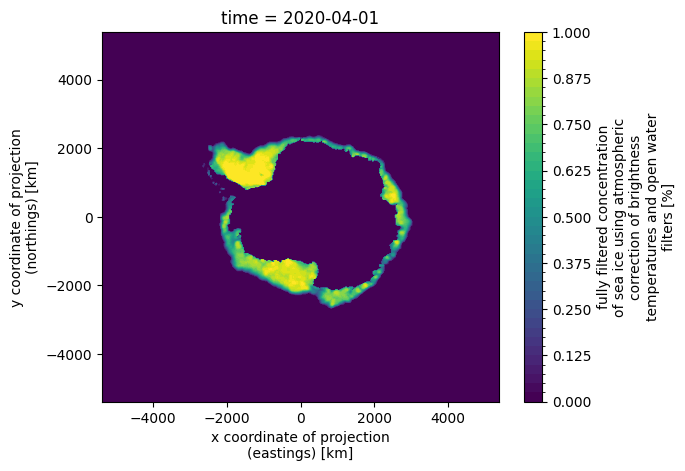

In [36]:
# Load original input dataset (domain not normalised)
xr.plot.contourf(xr.open_dataset("data/osisaf/south/siconca/2020.nc").isel(time=91).ice_conc, levels=50)

## Version
- IceNet Codebase: v0.2.7_dev